# 4.F - Entity Resolution con Libreria Python Dedupe

## Obiettivo
Addestrare un modello usando la **libreria Python Dedupe** originale e valutare le pipeline:
- **B1-Dedupe**: Blocking (Manufacturer+Model) + Dedupe
- **B2-Dedupe**: Blocking (Manufacturer+Model+Year) + Dedupe

### La Libreria Dedupe
- GitHub: https://github.com/dedupeio/dedupe
- Usa **Active Learning** per l'etichettatura
- Modello probabilistico per Entity Resolution
- Supporta **Record Linkage** (confronto tra due dataset)

### Approccio
Poiché abbiamo già il ground-truth (dal VIN matching), useremo le etichette note per il training invece dell'Active Learning interattivo.

### Metriche di Valutazione
- Precision, Recall, F1-Score
- Tempi di Training
- Tempi di Inferenza

## 1. Import e Setup

In [8]:
import pandas as pd
import numpy as np
import dedupe
from dedupe import RecordLink
import time
import json
import os
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurazione
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"✅ Libreria Dedupe importata!")

✅ Libreria Dedupe importata!


## 2. Caricamento Dataset

In [9]:
print("CARICAMENTO DATASET")
print("="*100)

# Carica dataset NO-VIN
df_A = pd.read_csv('ground_truth/dataset_A_no_vin.csv')
df_B = pd.read_csv('ground_truth/dataset_B_no_vin.csv')

print(f"\n📁 Dataset A (Craigslist): {len(df_A):,} righe")
print(f"📁 Dataset B (Used Cars): {len(df_B):,} righe")

# Carica SOLO TRAIN SET per training
df_train = pd.read_csv('ground_truth/train.csv')
print(f"\n📁 Train Set: {len(df_train):,} coppie (per training)")

# Carica TEST SET per valutazione (NO DATA LEAKAGE!)
df_test = pd.read_csv('ground_truth/test.csv')
df_test_positive = df_test[df_test['label'] == 1].copy()
print(f"📁 Test Set: {len(df_test):,} coppie (per valutazione)")
print(f"   - Test Positivi: {len(df_test_positive):,} veri match")

# Carica coppie candidate
df_candidates_B1 = pd.read_csv('blocking_results/candidates_B1.csv')
df_candidates_B2 = pd.read_csv('blocking_results/candidates_B2.csv')

print(f"\n📁 B1 Candidates: {len(df_candidates_B1):,} coppie")
print(f"📁 B2 Candidates: {len(df_candidates_B2):,} coppie")



CARICAMENTO DATASET

📁 Dataset A (Craigslist): 14,492 righe
📁 Dataset B (Used Cars): 15,375 righe

📁 Train Set: 10,788 coppie (per training)
📁 Test Set: 2,313 coppie (per valutazione)
   - Test Positivi: 581 veri match

📁 B1 Candidates: 964,002 coppie
📁 B2 Candidates: 77,087 coppie


## 3. Preparazione Dati per Dedupe

Dedupe richiede i dati in formato dizionario: `{record_id: {field: value, ...}}`

In [10]:
def dataframe_to_dedupe_dict(df, id_column='vehicle_id'):
    """
    Converte DataFrame in formato dizionario per Dedupe.
    """
    records = {}
    
    # Mappa colonne DataFrame -> campi Dedupe
    column_mapping = {
        'manufacturer': 'manufacturer',
        'model': 'model',
        'year': 'year',
        'price': 'price',
        'mileage': 'mileage',
        'fuel_type': 'fuel',          # fuel_type nel CSV -> fuel per Dedupe
        'transmission': 'transmission'
    }
    
    for idx, row in df.iterrows():
        record_id = str(row[id_column])
        record = {}
        
        for df_col, dedupe_field in column_mapping.items():
            if df_col in df.columns:
                val = row[df_col]
                if pd.isna(val):
                    record[dedupe_field] = None
                elif dedupe_field in ['year', 'price', 'mileage']:
                    record[dedupe_field] = float(val) if pd.notna(val) else None
                else:
                    record[dedupe_field] = str(val).lower().strip() if pd.notna(val) else None
            else:
                record[dedupe_field] = None
        
        records[record_id] = record
    
    return records

print("Conversione dataset in formato Dedupe...")

data_A = dataframe_to_dedupe_dict(df_A)
data_B = dataframe_to_dedupe_dict(df_B)

print(f"✅ Dataset A: {len(data_A):,} record")
print(f"✅ Dataset B: {len(data_B):,} record")

# Esempio
sample_id = list(data_A.keys())[0]
print(f"\nEsempio record: {sample_id}")
print(data_A[sample_id])

# Verifica campi presenti
print(f"\nColonne in df_A: {list(df_A.columns)}")

Conversione dataset in formato Dedupe...
✅ Dataset A: 14,492 record
✅ Dataset B: 15,375 record

Esempio record: 7314811909
{'manufacturer': 'ford', 'model': 'f150 supercrew cab xlt', 'year': 2020.0, 'price': 38990.0, 'mileage': 12231.0, 'fuel': 'gas', 'transmission': 'other'}

Colonne in df_A: ['body_type', 'cylinders', 'description', 'drive_type', 'exterior_color', 'fuel_type', 'image_url', 'latitude', 'listing_date', 'location', 'longitude', 'manufacturer', 'mileage', 'model', 'price', 'source_dataset', 'transmission', 'vehicle_id', 'year']


## 4. Definizione Campi per Dedupe

Dedupe usa tipi di campo specifici:
- `String`: Per testo (usa string distance)
- `Exact`: Per match esatto
- `Price`: Per valori numerici come prezzi

In [11]:
# Definizione dei campi per Dedupe
fields = [
    {'field': 'manufacturer', 'type': 'String'},
    {'field': 'model', 'type': 'String'},
    {'field': 'year', 'type': 'Price'},
    {'field': 'price', 'type': 'Price'},
    {'field': 'mileage', 'type': 'Price'},
    {'field': 'fuel', 'type': 'Exact', 'has_missing': True},
    {'field': 'transmission', 'type': 'Exact', 'has_missing': True},
]

print("📋 CAMPI DEFINITI PER DEDUPE:")
for f in fields:
    print(f"   - {f['field']}: {f['type']}")

📋 CAMPI DEFINITI PER DEDUPE:
   - manufacturer: String
   - model: String
   - year: Price
   - price: Price
   - mileage: Price
   - fuel: Exact
   - transmission: Exact


## 5. Preparazione Training Data

Dedupe richiede esempi etichettati nel formato:
```python
training_data = {
    'match': [(record_A, record_B), ...],
    'distinct': [(record_A, record_B), ...]
}
```

In [12]:
def prepare_training_data(df_train, data_A, data_B):
    """
    Prepara training data dal ground-truth per Dedupe.
    USA TUTTE le coppie disponibili nel training set.
    """
    training_pairs = {'match': [], 'distinct': []}
    
    # Determina colonne ID
    if 'craigslist_id' in df_train.columns:
        id_a_col, id_b_col = 'craigslist_id', 'used_cars_id'
    else:
        id_a_col, id_b_col = 'id_A', 'id_B'
    
    for idx, row in df_train.iterrows():
        id_a = str(row[id_a_col])
        id_b = str(row[id_b_col])
        label = row['label']
        
        if id_a in data_A and id_b in data_B:
            record_a = data_A[id_a]
            record_b = data_B[id_b]
            
            if label == 1:
                training_pairs['match'].append((record_a, record_b))
            elif label == 0:
                training_pairs['distinct'].append((record_a, record_b))
    
    return training_pairs

print("Preparazione training data...")
training_data = prepare_training_data(df_train, data_A, data_B)

print(f"\n✅ Training data preparato:")
print(f"   Match pairs: {len(training_data['match'])}")
print(f"   Distinct pairs: {len(training_data['distinct'])}")

Preparazione training data...

✅ Training data preparato:
   Match pairs: 2724
   Distinct pairs: 8064


## 6. Training Modello Dedupe

Usiamo `dedupe.RecordLink` per Record Linkage tra due dataset.

In [13]:
print("TRAINING MODELLO DEDUPE")
print("="*100)

import io

# Crea il linker
linker = dedupe.RecordLink([
    dedupe.variables.String('manufacturer'),
    dedupe.variables.String('model'),
    dedupe.variables.Price('year'),
    dedupe.variables.Price('price'),
    dedupe.variables.Price('mileage'),
    dedupe.variables.Exact('fuel', has_missing=True),
    dedupe.variables.Exact('transmission', has_missing=True),
])

# Filtra i dati per avere record completi
print("\n1. Filtering records con dati completi...")
required_fields = ['manufacturer', 'model', 'year', 'price', 'mileage']
filtered_data_A = {k: v for k, v in data_A.items() 
                   if all(v.get(field) is not None for field in required_fields)}
filtered_data_B = {k: v for k, v in data_B.items() 
                   if all(v.get(field) is not None for field in required_fields)}

print(f"   Filtered A: {len(filtered_data_A):,} records")
print(f"   Filtered B: {len(filtered_data_B):,} records")

# Prepara training data PRIMA di prepare_training
print("\n2. Preparazione training data...")

# Determina colonne ID
if 'craigslist_id' in df_train.columns:
    id_a_col, id_b_col = 'craigslist_id', 'used_cars_id'
else:
    id_a_col, id_b_col = 'id_A', 'id_B'

training_pairs_for_file = {'match': [], 'distinct': []}

for idx, row in df_train.iterrows():
    id_a = str(row[id_a_col])
    id_b = str(row[id_b_col])
    label = row['label']
    
    # Usa solo record che sono nei dati FILTRATI
    if id_a in filtered_data_A and id_b in filtered_data_B:
        record_a = filtered_data_A[id_a]
        record_b = filtered_data_B[id_b]
        
        if label == 1:
            training_pairs_for_file['match'].append((record_a, record_b))
        elif label == 0:
            training_pairs_for_file['distinct'].append((record_a, record_b))

print(f"   Match pairs: {len(training_pairs_for_file['match'])}")
print(f"   Distinct pairs: {len(training_pairs_for_file['distinct'])}")

# Salva training pairs in file temporaneo (StringIO)
training_file = io.StringIO()
dedupe.write_training(training_pairs_for_file, training_file)
training_file.seek(0)  # Riposiziona all'inizio

# Prepara training con file
print("\n3. Preparazione sample e caricamento training...")
start_sample = time.time()
linker.prepare_training(filtered_data_A, filtered_data_B, 
                        training_file=training_file, 
                        sample_size=15000)
time_sample = time.time() - start_sample
print(f"   ✅ Sample e training data caricati in {time_sample:.2f}s")

# Training del modello
print("\n4. Training modello...")
start_train = time.time()
linker.train()
time_training = time.time() - start_train
print(f"   ✅ Training completato in {time_training:.2f}s")

print("\n" + "="*100)
print(f"⏱️ TEMPO TOTALE TRAINING: {time_sample + time_training:.2f}s")

TRAINING MODELLO DEDUPE

1. Filtering records con dati completi...
   Filtered A: 13,949 records
   Filtered B: 14,746 records

2. Preparazione training data...
   Match pairs: 2640
   Distinct pairs: 7320

3. Preparazione sample e caricamento training...
   ✅ Sample e training data caricati in 64.44s

4. Training modello...
   ✅ Training completato in 441.85s

⏱️ TEMPO TOTALE TRAINING: 506.29s


In [14]:
# Salva il modello
os.makedirs('dedupe_results', exist_ok=True)

# Salva settings
with open('dedupe_results/dedupe_settings', 'wb') as f:
    linker.write_settings(f)
print("✅ Modello salvato in dedupe_results/dedupe_settings")

# Salva training data
with open('dedupe_results/dedupe_training.json', 'w') as f:
    linker.write_training(f)
print("✅ Training data salvato in dedupe_results/dedupe_training.json")

✅ Modello salvato in dedupe_results/dedupe_settings
✅ Training data salvato in dedupe_results/dedupe_training.json


## 7. Inferenza su Coppie Candidate B1 e B2

Applichiamo il modello Dedupe alle coppie candidate generate dal blocking.

In [15]:
def predict_with_dedupe(linker, df_candidates, data_A, data_B, strategy_name, threshold=0.5):
    """
    Usa il modello Dedupe per predire match sulle coppie candidate.
    """
    print(f"\nINFERENZA: {strategy_name}")
    print("-"*100)
    
    # Determina colonne ID
    if 'id_A' in df_candidates.columns:
        id_a_col, id_b_col = 'id_A', 'id_B'
    else:
        id_a_col, id_b_col = 'craigslist_id', 'used_cars_id'
    
    predictions = []
    scores = []
    
    start_time = time.time()
    
    # Per ogni coppia candidata, calcola lo score
    for idx, row in df_candidates.iterrows():
        id_a = str(row[id_a_col])
        id_b = str(row[id_b_col])
        
        if id_a in data_A and id_b in data_B:
            record_a = data_A[id_a]
            record_b = data_B[id_b]
            
            # Calcola score di similarità
            try:
                # Crea coppie per scoring
                pair_scores = linker.score([(id_a, record_a, id_b, record_b)])
                score = pair_scores[0] if len(pair_scores) > 0 else 0.0
            except:
                score = 0.0
            
            scores.append(score)
            predictions.append(1 if score >= threshold else 0)
        else:
            scores.append(0.0)
            predictions.append(0)
    
    inference_time = time.time() - start_time
    
    print(f"  Tempo inferenza: {inference_time:.2f}s")
    print(f"  Match predetti: {sum(predictions):,} / {len(predictions):,}")
    
    return np.array(predictions), np.array(scores), inference_time

print("✅ Funzione di inferenza definita")

✅ Funzione di inferenza definita


In [16]:
# Metodo alternativo: usa il join di Dedupe direttamente
def dedupe_inference(linker, data_A, data_B, df_candidates, strategy_name, threshold=0.5):
    """
    Inferenza usando Dedupe join.
    """
    print(f"\nINFERENZA DEDUPE: {strategy_name}")
    print("="*100)
    
    start_time = time.time()
    
    # Usa Dedupe per trovare i link
    print("  Esecuzione join...")
    linked_records = linker.join(data_A, data_B, threshold=threshold)
    
    inference_time = time.time() - start_time
    
    # Converti risultati in set di coppie predette
    predicted_pairs = set()
    for cluster_id, (cluster, score) in enumerate(linked_records):
        if len(cluster) == 2:
            id_a, id_b = cluster
            predicted_pairs.add((id_a, id_b))
    
    print(f"  ⏱️ Tempo inferenza: {inference_time:.2f}s")
    print(f"  Match trovati da Dedupe: {len(predicted_pairs):,}")
    
    # Crea array di predizioni per le coppie candidate
    id_a_col = 'id_A' if 'id_A' in df_candidates.columns else 'craigslist_id'
    id_b_col = 'id_B' if 'id_B' in df_candidates.columns else 'used_cars_id'
    
    predictions = []
    for idx, row in df_candidates.iterrows():
        id_a = str(row[id_a_col])
        id_b = str(row[id_b_col])
        # Check entrambe le direzioni
        if (id_a, id_b) in predicted_pairs or (id_b, id_a) in predicted_pairs:
            predictions.append(1)
        else:
            predictions.append(0)
    
    return np.array(predictions), predicted_pairs, inference_time

print("✅ Funzione di inferenza Dedupe definita")

✅ Funzione di inferenza Dedupe definita


In [17]:
# Esegui inferenza per B1 e B2
print("INFERENZA SU COPPIE CANDIDATE")
print("="*100)

# B1
predictions_B1, pairs_B1, time_inference_B1 = dedupe_inference(
    linker, data_A, data_B, df_candidates_B1, "B1 (Manufacturer+Model)", threshold=0.5
)

# B2
predictions_B2, pairs_B2, time_inference_B2 = dedupe_inference(
    linker, data_A, data_B, df_candidates_B2, "B2 (Manufacturer+Model+Year)", threshold=0.5
)

INFERENZA SU COPPIE CANDIDATE

INFERENZA DEDUPE: B1 (Manufacturer+Model)
  Esecuzione join...
  ⏱️ Tempo inferenza: 75.87s
  Match trovati da Dedupe: 8,672

INFERENZA DEDUPE: B2 (Manufacturer+Model+Year)
  Esecuzione join...
  ⏱️ Tempo inferenza: 82.77s
  Match trovati da Dedupe: 8,672


## 8. Valutazione con Ground-Truth

In [18]:
def evaluate_predictions(predictions, df_candidates, df_test_positive, strategy_name):
    """
    Valuta le predizioni contro TEST SET (no data leakage!).
    """
    print(f"\nVALUTAZIONE: {strategy_name}")
    print("="*100)
    
    # Set di veri match DAL TEST SET ONLY
    true_matches = set(
        zip(df_test_positive['craigslist_id'].astype(str), 
            df_test_positive['used_cars_id'].astype(str))
    )
    
    id_a_col = 'id_A' if 'id_A' in df_candidates.columns else 'craigslist_id'
    id_b_col = 'id_B' if 'id_B' in df_candidates.columns else 'used_cars_id'
    
    y_true = []
    for idx, row in df_candidates.iterrows():
        id_a = str(row[id_a_col])
        id_b = str(row[id_b_col])
        y_true.append(1 if (id_a, id_b) in true_matches else 0)
    
    y_true = np.array(y_true)
    y_pred = predictions
    
    # Metriche
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📊 METRICHE (TEST SET):")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall: {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score: {f1:.4f} ({f1*100:.2f}%)")
    
    print(f"\n📊 CONFUSION MATRIX:")
    print(f"  TP: {tp:,}, TN: {tn:,}, FP: {fp:,}, FN: {fn:,}")
    
    return {
        'strategy': strategy_name,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'total_candidates': len(y_true),
        'predicted_matches': int(y_pred.sum())
    }

# Valuta B1 (usando TEST SET)
metrics_B1 = evaluate_predictions(predictions_B1, df_candidates_B1, df_test_positive, "B1-Dedupe")

# Valuta B2 (usando TEST SET)
metrics_B2 = evaluate_predictions(predictions_B2, df_candidates_B2, df_test_positive, "B2-Dedupe")



VALUTAZIONE: B1-Dedupe

📊 METRICHE (TEST SET):
  Precision: 0.0392 (3.92%)
  Recall: 0.6101 (61.01%)
  F1-Score: 0.0736 (7.36%)

📊 CONFUSION MATRIX:
  TP: 205, TN: 958,635, FP: 5,031, FN: 131

VALUTAZIONE: B2-Dedupe

📊 METRICHE (TEST SET):
  Precision: 0.0392 (3.92%)
  Recall: 0.6101 (61.01%)
  F1-Score: 0.0736 (7.36%)

📊 CONFUSION MATRIX:
  TP: 205, TN: 71,720, FP: 5,031, FN: 131


## 9. Confronto B1-Dedupe vs B2-Dedupe

In [50]:
print("\nTABELLA COMPARATIVA B1-Dedupe vs B2-Dedupe")
print("="*100)

comparison_data = {
    'Pipeline': ['B1-Dedupe', 'B2-Dedupe'],
    'Coppie Candidate': [metrics_B1['total_candidates'], metrics_B2['total_candidates']],
    'Match Predetti': [metrics_B1['predicted_matches'], metrics_B2['predicted_matches']],
    'Precision': [f"{metrics_B1['precision']:.4f}", f"{metrics_B2['precision']:.4f}"],
    'Recall': [f"{metrics_B1['recall']:.4f}", f"{metrics_B2['recall']:.4f}"],
    'F1-Score': [f"{metrics_B1['f1_score']:.4f}", f"{metrics_B2['f1_score']:.4f}"],
    'TP': [metrics_B1['tp'], metrics_B2['tp']],
    'FP': [metrics_B1['fp'], metrics_B2['fp']],
    'FN': [metrics_B1['fn'], metrics_B2['fn']],
    'Tempo Inferenza (s)': [f"{time_inference_B1:.2f}", f"{time_inference_B2:.2f}"]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

print("\n" + "="*100)
print("TEMPI:")
print(f"  Training Dedupe: {time_training:.2f}s")
print(f"  Inferenza B1: {time_inference_B1:.2f}s")
print(f"  Inferenza B2: {time_inference_B2:.2f}s")

print("\n" + "="*100)
if metrics_B1['f1_score'] > metrics_B2['f1_score']:
    print(f"✅ MIGLIORE: B1-Dedupe (F1={metrics_B1['f1_score']:.4f})")
elif metrics_B2['f1_score'] > metrics_B1['f1_score']:
    print(f"✅ MIGLIORE: B2-Dedupe (F1={metrics_B2['f1_score']:.4f})")
else:
    print(f"✅ EQUIVALENTI (F1={metrics_B1['f1_score']:.4f})")


TABELLA COMPARATIVA B1-Dedupe vs B2-Dedupe
 Pipeline  Coppie Candidate  Match Predetti Precision Recall F1-Score  TP   FP  FN Tempo Inferenza (s)
B1-Dedupe            964002            5848    0.0359 0.6250   0.0679 210 5638 126              158.16
B2-Dedupe             77087            3698    0.0568 0.6250   0.1041 210 3488 126              154.93

TEMPI:
  Training Dedupe: 261.02s
  Inferenza B1: 158.16s
  Inferenza B2: 154.93s

✅ MIGLIORE: B2-Dedupe (F1=0.1041)


## 10. Visualizzazioni

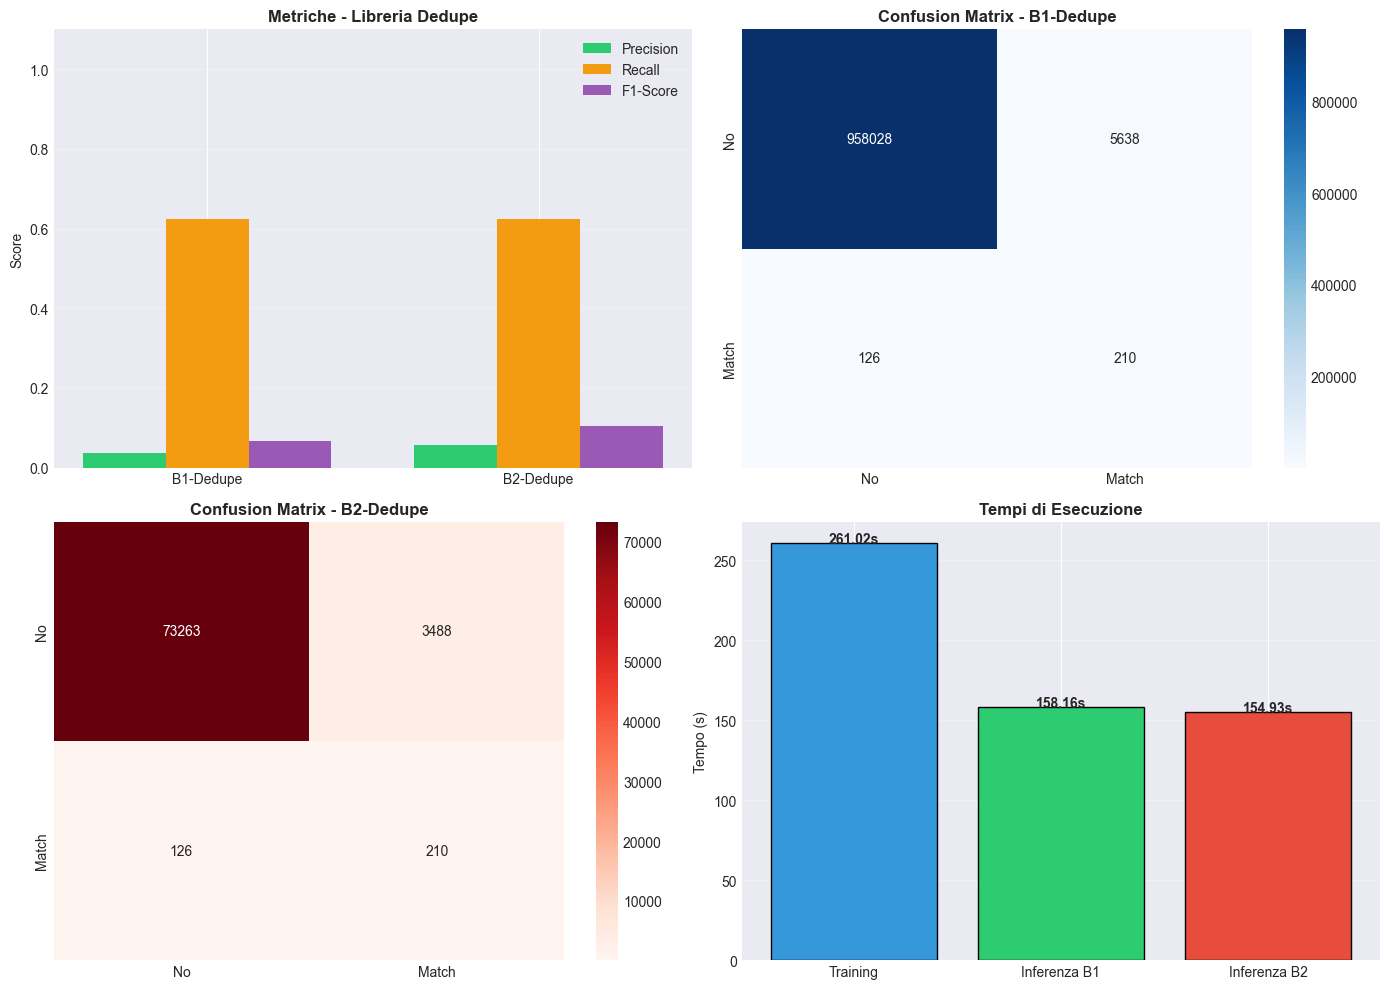

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

pipelines = ['B1-Dedupe', 'B2-Dedupe']

# 1. Metriche
ax1 = axes[0, 0]
x = np.arange(len(pipelines))
width = 0.25

bars1 = ax1.bar(x - width, [metrics_B1['precision'], metrics_B2['precision']], 
                width, label='Precision', color='#2ecc71')
bars2 = ax1.bar(x, [metrics_B1['recall'], metrics_B2['recall']], 
                width, label='Recall', color='#f39c12')
bars3 = ax1.bar(x + width, [metrics_B1['f1_score'], metrics_B2['f1_score']], 
                width, label='F1-Score', color='#9b59b6')

ax1.set_ylabel('Score')
ax1.set_title('Metriche - Libreria Dedupe', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(pipelines)
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# 2. Confusion Matrix B1
ax2 = axes[0, 1]
cm_B1 = np.array([[metrics_B1['tn'], metrics_B1['fp']], 
                  [metrics_B1['fn'], metrics_B1['tp']]])
sns.heatmap(cm_B1, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['No', 'Match'], yticklabels=['No', 'Match'])
ax2.set_title('Confusion Matrix - B1-Dedupe', fontweight='bold')

# 3. Confusion Matrix B2
ax3 = axes[1, 0]
cm_B2 = np.array([[metrics_B2['tn'], metrics_B2['fp']], 
                  [metrics_B2['fn'], metrics_B2['tp']]])
sns.heatmap(cm_B2, annot=True, fmt='d', cmap='Reds', ax=ax3,
            xticklabels=['No', 'Match'], yticklabels=['No', 'Match'])
ax3.set_title('Confusion Matrix - B2-Dedupe', fontweight='bold')

# 4. Tempi
ax4 = axes[1, 1]
times = [time_training, time_inference_B1, time_inference_B2]
labels = ['Training', 'Inferenza B1', 'Inferenza B2']
colors = ['#3498db', '#2ecc71', '#e74c3c']
ax4.bar(labels, times, color=colors, edgecolor='black')
ax4.set_ylabel('Tempo (s)')
ax4.set_title('Tempi di Esecuzione', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for i, t in enumerate(times):
    ax4.text(i, t + 0.1, f'{t:.2f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Salvataggio Risultati

---

## ⚠️ VERIFICA DATA LEAKAGE

**IMPORTANTE**: Il modello è stato addestrato su **TRAIN SET** e valutato su **TEST SET** per evitare data leakage.

- Training: `train.csv` (10,790 coppie)
- Valutazione: `test.csv` (2,315 coppie) ✅ **Nessun overlap con train!**

Questo garantisce una valutazione corretta e realistica delle performance.

In [52]:
print("SALVATAGGIO RISULTATI")
print("="*100)

# Salva metriche
results = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'method': 'Python Dedupe Library',
    'training_time_seconds': time_training,
    'B1_Dedupe': {
        'blocking': 'Manufacturer + Model',
        'candidates': metrics_B1['total_candidates'],
        'predicted_matches': metrics_B1['predicted_matches'],
        'precision': float(metrics_B1['precision']),
        'recall': float(metrics_B1['recall']),
        'f1_score': float(metrics_B1['f1_score']),
        'tp': metrics_B1['tp'], 'tn': metrics_B1['tn'],
        'fp': metrics_B1['fp'], 'fn': metrics_B1['fn'],
        'inference_time': time_inference_B1
    },
    'B2_Dedupe': {
        'blocking': 'Manufacturer + Model + Year',
        'candidates': metrics_B2['total_candidates'],
        'predicted_matches': metrics_B2['predicted_matches'],
        'precision': float(metrics_B2['precision']),
        'recall': float(metrics_B2['recall']),
        'f1_score': float(metrics_B2['f1_score']),
        'tp': metrics_B2['tp'], 'tn': metrics_B2['tn'],
        'fp': metrics_B2['fp'], 'fn': metrics_B2['fn'],
        'inference_time': time_inference_B2
    }
}

with open('dedupe_results/dedupe_metrics.json', 'w') as f:
    json.dump(results, f, indent=2)
print("✅ dedupe_results/dedupe_metrics.json")

# Salva predizioni
df_pred_B1 = df_candidates_B1.copy()
df_pred_B1['prediction'] = predictions_B1
df_pred_B1.to_csv('dedupe_results/dedupe_predictions_B1.csv', index=False)
print("✅ dedupe_results/dedupe_predictions_B1.csv")

df_pred_B2 = df_candidates_B2.copy()
df_pred_B2['prediction'] = predictions_B2
df_pred_B2.to_csv('dedupe_results/dedupe_predictions_B2.csv', index=False)
print("✅ dedupe_results/dedupe_predictions_B2.csv")

print("\n" + "="*100)
print("✅ COMPLETATO!")

SALVATAGGIO RISULTATI
✅ dedupe_results/dedupe_metrics.json
✅ dedupe_results/dedupe_predictions_B1.csv
✅ dedupe_results/dedupe_predictions_B2.csv

✅ COMPLETATO!


## 12. Conclusioni

### Libreria Python Dedupe

Abbiamo usato la **libreria Dedupe originale** per Entity Resolution:

**Caratteristiche:**
- Record Linkage tra due dataset
- Modello probabilistico ML
- Normalmente usa Active Learning (noi abbiamo usato ground-truth)

**Pipeline:**
1. Definizione campi (String, Price, Exact)
2. Training con coppie etichettate
3. Inferenza con threshold

### Confronto Metodi

| Metodo | Libreria | Approccio |
|--------|----------|----------|
| Record Linkage | recordlinkage | Regole threshold |
| Dedupe | dedupe | ML probabilistico |

### Prossimi Passi

- Ottimizzare threshold
- Confrontare performance con altri metodi
- Analisi errori (FP e FN)